In [1]:
from google.colab import files
uploaded = files.upload()

Saving bank-full.csv to bank-full.csv


In [2]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef
)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load dataset
df = pd.read_csv("bank-full.csv", sep=";")

# Target encoding
df["y"] = df["y"].map({"no": 0, "yes": 1})

In [4]:
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


In [5]:
df.shape

(45211, 17)

# Check for Class Imbalance

In [6]:
df['y'].value_counts()

,count
y,
0,39922
1,5289


#### **Inference:** Dataset is not balanced. Hence, class balancing needs to be implemented at the time of modelling.

# Check for Null Entries

In [7]:
# Create a list to store the data for the new DataFrame
data = []

# Iterate over each column in the DataFrame
for col in df.columns:
    non_null_count = df[col].count()
    null_count = df[col].isnull().sum()
    data.append([col, non_null_count, null_count])

# Create the new DataFrame
new_df = pd.DataFrame(data, columns=['feature name', 'count of non null', 'count of null'])
new_df

,feature name,count of non null,count of null
0,age,45211,0
1,job,45211,0
2,marital,45211,0
3,education,45211,0
4,default,45211,0
5,balance,45211,0
6,housing,45211,0
7,loan,45211,0
8,contact,45211,0
9,day,45211,0


#### **Observation:** Dataset has no Null entries

In [8]:
cat_cols = df.select_dtypes(include="object").columns
num_cols = df.select_dtypes(exclude="object").columns

print(f"Categorical columns: {list(cat_cols)}")
print()
print(f"Numerical columns: {list(num_cols)}")
print()

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']



# Univariate Analysis

In [9]:
df[num_cols].drop('y',axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


#### **Inference:**
The dataset represents a middle-aged population where most individuals have not been contacted previously. The financial data is highly variable and right-skewed, suggesting a mix of customers with low **balances/debt** and a few very wealthy individuals. We will need to normalize the data (specifically for **balance, duration, and campaign**) before feeding this into a machine learning model.

# Check for Multi-collinearity and Associations amongst predictors

### Utility Functions

1. **perform_chi_square():** Tests the independence between categorical predictors and a categorical target. It helps determine if a feature has a statistically significant relationship with the outcome.

2. **perform_anova():** Determines if the mean of a numeric predictor varies significantly across the different levels of a categorical target. It identifies numeric features that distinguish between classes.

3. **get_clean_numeric_features():** Calculates Pearson Correlation between numeric predictors. If two features are highly correlated (high multicollinearity), one is dropped to remove redundancy; otherwise, all are retained.

4. **get_clean_categorical_features():** Measures the strength of association between categorical predictors using Cramér’s V. If features are too closely related, the redundant ones are dropped to simplify the model.

In [10]:
from scipy.stats import chi2_contingency, f_oneway

def perform_chi_square(df: pd.DataFrame, var1: str, var2: str):
    """Performs a Chi-square test between two categorical variables."""
    print(f"\n--- Chi-square Test: '{var1}' vs '{var2}' ---")
    # Create a contingency table (cross-tabulation)
    contingency_table = pd.crosstab(df[var1], df[var2])

    # Perform the test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-square Statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("Result: The variables are likely dependent (p < 0.05).")
    else:
        print("Result: The variables are likely independent (p >= 0.05).")

def perform_anova(df: pd.DataFrame, cat_var: str, cont_var):
    """Performs ANOVA between a categorical and a continuous variable."""
    print(f"\n--- ANOVA Test: '{cat_var}' vs '{cont_var}' ---")

    # Get unique categories and create a list of data for each category
    groups = df[cat_var].unique()
    grouped_data = [df[cont_var][df[cat_var] == g] for g in groups if pd.notna(g)]

    # Perform the test
    f_stat, p_value = f_oneway(*grouped_data)

    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"Result: There is a significant difference in '{cont_var}' across '{cat_var}' groups (p < 0.05).")
    else:
        print(f"Result: There is no significant difference in '{cont_var}' across '{cat_var}' groups (p >= 0.05).")

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway

def get_clean_numeric_features(df, num_cols, target=None, threshold=0.8):
    """
    Analyzes Pearson Correlation between numeric features.
    """
    print("\n--- 1. Numeric vs. Numeric Analysis (Pearson) ---")
    data = df[num_cols].drop(columns=[target], errors='ignore')
    corr_matrix = data.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify high correlation pairs
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    high_corr_pairs = [(column, upper.index[i]) for column in upper.columns
                       for i, val in enumerate(upper[column]) if val > threshold]

    if high_corr_pairs:
        print(f"{'Feature A':<20} | {'Feature B':<20} | {'Correlation':<10}")
        print("-" * 55)
        for p in high_corr_pairs:
            val = corr_matrix.loc[p[0], p[1]]
            print(f"{p[0]:<20} | {p[1]:<20} | {val:.4f}")
    else:
        print("No high multi-collinearity detected.")

    selected_features = [c for c in data.columns if c not in to_drop]
    return selected_features


def get_clean_categorical_features(df, cat_cols, target=None, threshold=0.8):
    """
    Analyzes Association between categorical features using Cramér's V.
    """
    print("\n--- 2. Categorical vs. Categorical Analysis (Cramér's V) ---")
    data = df[cat_cols].drop(columns=[target], errors='ignore')
    cols = data.columns
    to_drop = set()
    high_assoc_pairs = []

    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            score = cramers_v(data[cols[i]], data[cols[j]])
            if score > threshold:
                high_assoc_pairs.append((cols[i], cols[j], score))
                to_drop.add(cols[j])

    if high_assoc_pairs:
        print(f"{'Feature A':<20} | {'Feature B':<20} | {'Cramér\'s V':<10}")
        print("-" * 55)
        for p in high_assoc_pairs:
            print(f"{p[0]:<20} | {p[1]:<20} | {p[2]:.4f}")
    else:
        print("No high association detected.")

    selected_features = [c for c in cols if c not in to_drop]
    return selected_features

In [12]:
for i in cat_cols:
  perform_chi_square(df, "y", i)


--- Chi-square Test: 'y' vs 'job' ---
Chi-square Statistic: 836.1055
P-value: 0.0000
Result: The variables are likely dependent (p < 0.05).

--- Chi-square Test: 'y' vs 'marital' ---
Chi-square Statistic: 196.4959
P-value: 0.0000
Result: The variables are likely dependent (p < 0.05).

--- Chi-square Test: 'y' vs 'education' ---
Chi-square Statistic: 238.9235
P-value: 0.0000
Result: The variables are likely dependent (p < 0.05).

--- Chi-square Test: 'y' vs 'default' ---
Chi-square Statistic: 22.2022
P-value: 0.0000
Result: The variables are likely dependent (p < 0.05).

--- Chi-square Test: 'y' vs 'housing' ---
Chi-square Statistic: 874.8224
P-value: 0.0000
Result: The variables are likely dependent (p < 0.05).

--- Chi-square Test: 'y' vs 'loan' ---
Chi-square Statistic: 209.6170
P-value: 0.0000
Result: The variables are likely dependent (p < 0.05).

--- Chi-square Test: 'y' vs 'contact' ---
Chi-square Statistic: 1035.7142
P-value: 0.0000
Result: The variables are likely dependent (p

In [13]:
for i in num_cols:
  perform_anova(df, i, "y")


--- ANOVA Test: 'age' vs 'y' ---
F-statistic: 22.2861
P-value: 0.0000
Result: There is a significant difference in 'y' across 'age' groups (p < 0.05).

--- ANOVA Test: 'balance' vs 'y' ---
F-statistic: 1.5013
P-value: 0.0000
Result: There is a significant difference in 'y' across 'balance' groups (p < 0.05).

--- ANOVA Test: 'day' vs 'y' ---
F-statistic: 19.3678
P-value: 0.0000
Result: There is a significant difference in 'y' across 'day' groups (p < 0.05).

--- ANOVA Test: 'duration' vs 'y' ---
F-statistic: 8.4684
P-value: 0.0000
Result: There is a significant difference in 'y' across 'duration' groups (p < 0.05).

--- ANOVA Test: 'campaign' vs 'y' ---
F-statistic: 7.7019
P-value: 0.0000
Result: There is a significant difference in 'y' across 'campaign' groups (p < 0.05).

--- ANOVA Test: 'pdays' vs 'y' ---
F-statistic: 8.9055
P-value: 0.0000
Result: There is a significant difference in 'y' across 'pdays' groups (p < 0.05).

--- ANOVA Test: 'previous' vs 'y' ---
F-statistic: 35.4688


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [14]:
# 1. Numeric
final_nums = get_clean_numeric_features(df, num_cols, target='y')
final_nums


--- 1. Numeric vs. Numeric Analysis (Pearson) ---
No high multi-collinearity detected.


['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [15]:
# 2. Categorical
final_cats = get_clean_categorical_features(df, cat_cols, target='y')
final_cats


--- 2. Categorical vs. Categorical Analysis (Cramér's V) ---
No high association detected.


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

#### **Observation:**

1. There is a significant difference in 'y' across all numeric fields since p-value is less than 0.05.

2. The categorical variables are likely dependent on 'y' since p-value is less than 0.05.

3. There are no high multi-collinearity detected among numerical predictors.

4. There are no high association detected among categorical predictors.

#### **Inference:**

Keep all the variables and use them as predictors for the purpose of modelling.

# Visualisation

#### **correlation and plot the correlation between features.**

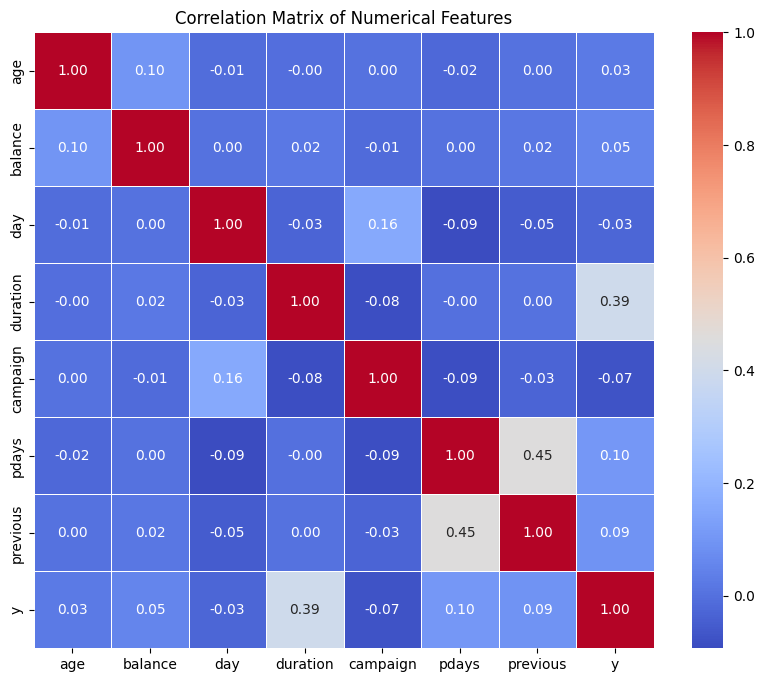

In [16]:
numerical_df = df.select_dtypes(include=[np.number])

corr_matrix = numerical_df.corr()

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Inference:** Numerical features generally show weak correlation; pdays and previous display the strongest positive relationship.

#### **check which age group is most likely to subscribe the bank.**

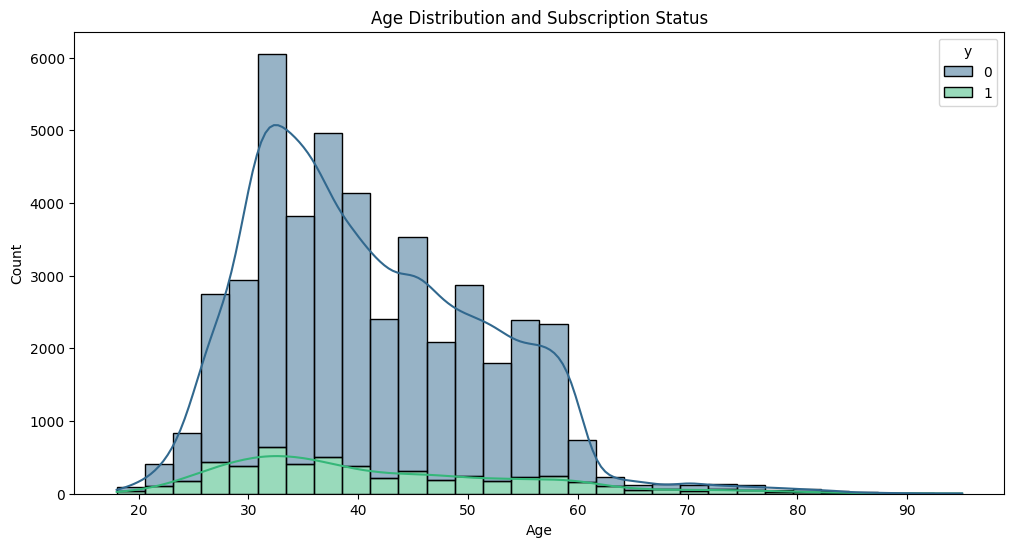

age
(10, 20]     0.340206
(20, 30]     0.160392
(30, 40]     0.102448
(40, 50]     0.090666
(50, 60]     0.100533
(60, 70]     0.405136
(70, 80]     0.451031
(80, 100]    0.434343
Name: y, dtype: float64


/tmp/ipython-input-1524071801.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(pd.cut(df['age'], bins=[10,20,30,40,50,60,70,80,100]))['y'].mean())


In [18]:
plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='age', hue='y', kde=True, bins=30, palette='viridis', multiple='stack')

plt.title('Age Distribution and Subscription Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print(df.groupby(pd.cut(df['age'], bins=[10,20,30,40,50,60,70,80,100]))['y'].mean())

**Inference:** Clients under 30 and over 60 show higher subscription likelihood compared to the middle-aged majority.

#### **Number of contacts made in each month.**

/tmp/ipython-input-2071553056.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='month', order=month_order, palette='magma')


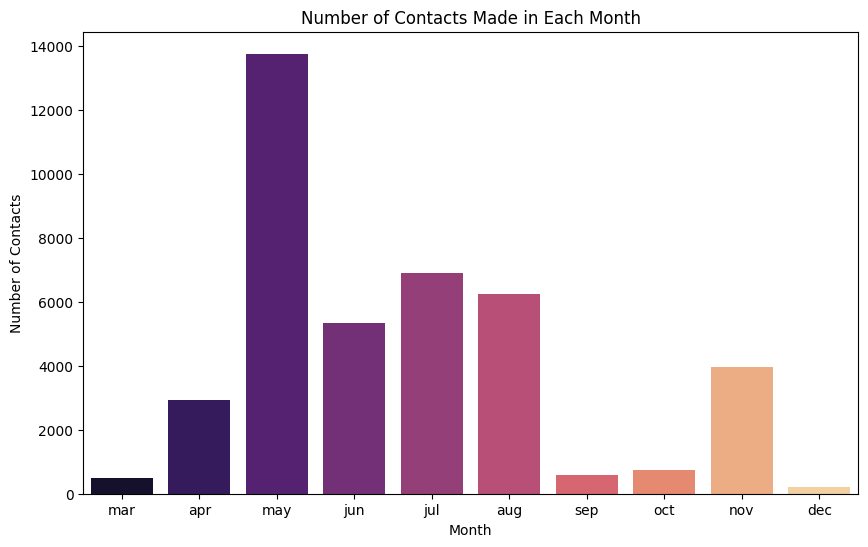

In [19]:
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='month', order=month_order, palette='magma')

plt.title('Number of Contacts Made in Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Contacts')
plt.show()

**Inference:** May records the highest contact volume, significantly outpacing other months, while December sees the least activity.

#### **The data grouped into education divisions and check which sector is more likely to subscribe.**

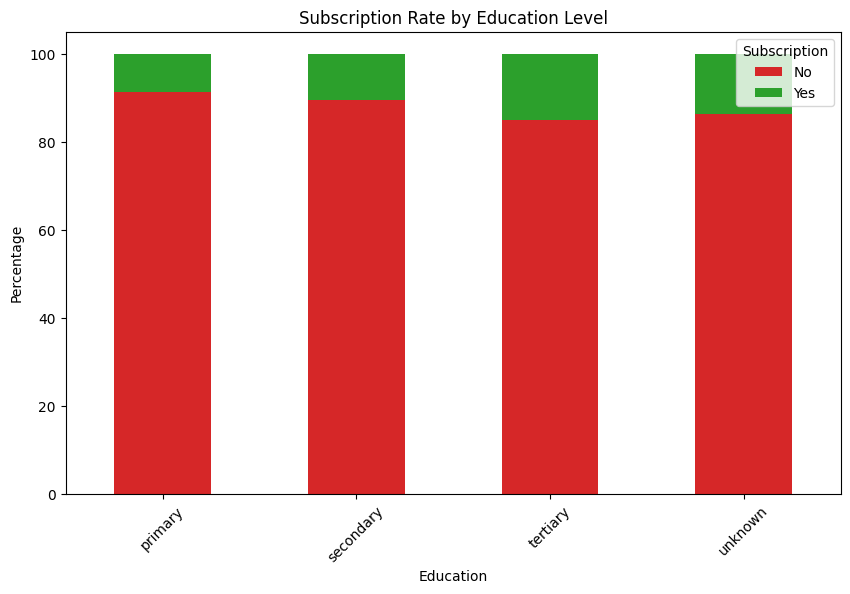

In [21]:
education_counts = pd.crosstab(df['education'], df['y'], normalize='index') * 100

ax = education_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#d62728', '#2ca02c'])

plt.title('Subscription Rate by Education Level')
plt.xlabel('Education')
plt.ylabel('Percentage')
plt.legend(title='Subscription', labels=['No', 'Yes'], loc='upper right')
plt.xticks(rotation=45)
plt.show()

**Inference:** Clients with tertiary education exhibit the highest subscription rate compared to other education levels.

#### **Total number of clients subscribed to the deposit.**

/tmp/ipython-input-531979952.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='y', palette='pastel')


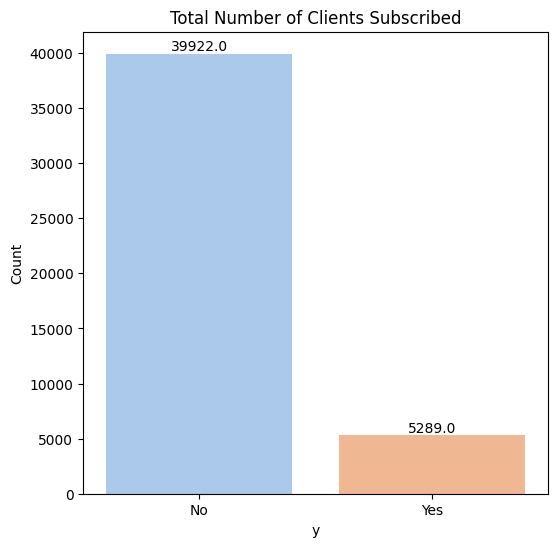

In [22]:
plt.figure(figsize=(6, 6))
ax = sns.countplot(data=df, x='y', palette='pastel')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.title('Total Number of Clients Subscribed')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Count')
plt.show()

**Inference:** The dataset is highly imbalanced, with significantly more non-subscribers than subscribers.

#### **How does the Job Type of the client affect their likelihood of subscribing to a term deposit?**

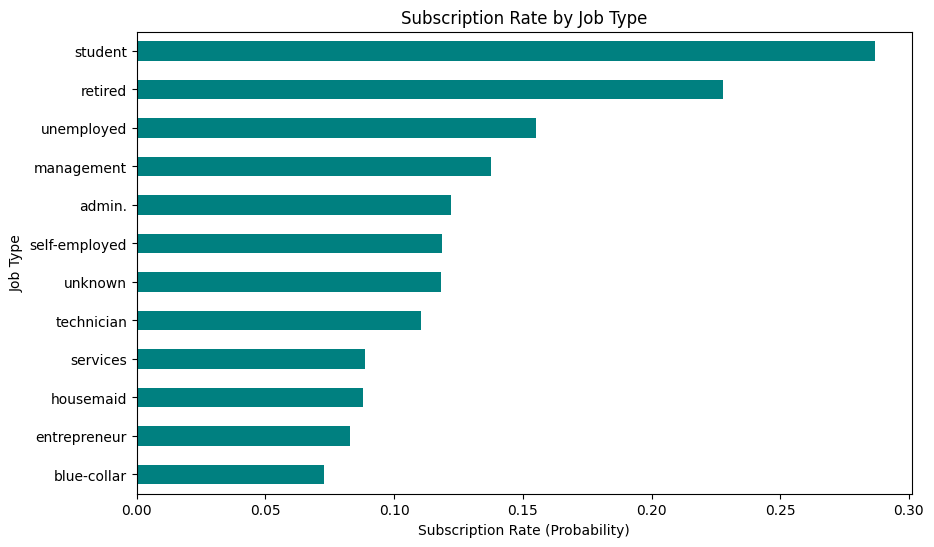

In [23]:
job_conversion = df.groupby('job')['y'].mean().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
job_conversion.plot(kind='barh', color='teal')

plt.title('Subscription Rate by Job Type')
plt.xlabel('Subscription Rate (Probability)')
plt.ylabel('Job Type')
plt.show()

**Inference:** Students and retired individuals demonstrate the highest subscription probability, while blue-collar workers show the lowest.